In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.cross_decomposition import CCA
import scipy

### Section 1

In [4]:
##load mnist background images 
train_set = np.loadtxt("..\mnist_background_random\mnist_background_random_train.amat")
test_set = np.loadtxt("..\mnist_background_random\mnist_background_random_test.amat") #for evaluate the model


In [5]:
print(train_set.shape)
print(test_set.shape)
#this is weird, I think these two sets is swapped
temp = train_set
train_set = test_set
test_set = temp
print(train_set.shape)
print(test_set.shape)

(12000, 785)
(50000, 785)
(50000, 785)
(12000, 785)


In [6]:
x_train = train_set[:, :-1] # except the label, feature shape = [50000, 784]
y_train = train_set[:, -1] # [50000, ]


x_test = test_set[:, :-1] # [12000, 784]
y_test = test_set[:, -1] # [12000, ]

In [7]:
indices_3 = np.where(y_train == 3)
indices_8 = np.where(y_train == 8)

x3_train = x_train[indices_3][:2000] #shape = [2000, 784]
y3_train = y_train[indices_3][:2000] #shape = [2000]

x8_train = x_train[indices_8][:2000]
y8_train = y_train[indices_8][:2000] #shape = [2000]  

x3_8_train = np.concatenate((x3_train, x8_train), axis=0) # [4000, 784]
y3_8_train = np.concatenate((y3_train, y8_train), axis=0) # [4000, ]

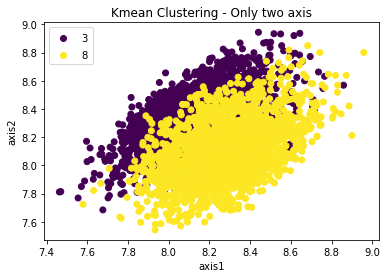

In [8]:
####Kmeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x3_8_train)
transformed_data_train = kmeans.transform(x3_8_train)
scat = plt.scatter(x=transformed_data_train[:,0], y=transformed_data_train[:,1], c=y3_8_train)
plt.xlabel("axis1")
plt.ylabel("axis2")
plt.title("Kmean Clustering - Only two axis")
plt.legend(*scat.legend_elements())

In [9]:
#####evaluate clustering accuracy and Normalized Mutual Information (NMI)
print(f"The MNI is: {normalized_mutual_info_score(kmeans.labels_, y3_8_train)}")
kmeans_labels_op1 = kmeans.labels_.copy()
kmeans_labels_op1[kmeans.labels_ == 0] = 3
kmeans_labels_op1[kmeans.labels_ == 1] = 8
kmeans_labels_op2 = kmeans.labels_.copy()
kmeans_labels_op2[kmeans.labels_ == 0] = 8
kmeans_labels_op2[kmeans.labels_ == 1] = 3
max_acc = np.max((accuracy_score(kmeans_labels_op1, y3_8_train), accuracy_score(kmeans_labels_op2, y3_8_train))) #there is two option of combinations
print(f"The max accuracy is: {max_acc}")


The MNI is: 0.3017209286865756
The max accuracy is: 0.811


### Section 2

In [10]:
x3_8_train_tilda = x3_8_train / np.linalg.norm(x3_8_train, axis=0, keepdims=True) #normalize the features

d_in=distance_matrix(x3_8_train_tilda, x3_8_train_tilda)
"""
num_samples = x3_8_train_tilda.shape[0]
dist_X = np.zeros((N, N))
for i in range(N):
    for j in range(i):
        dist_X[i, j] = np.linalg.norm(x3_8_train_tilda[i, :] - x3_8_train_tilda[j, :], 2)
dist_X = dist_X + dist_X.T
"""

c = 1
sigma = c * np.sort(d_in**2, axis=1)[:,1].max() #this is the Max-Min approach for finding the appropriate sigma.
print(f"The value of sigma is: {sigma}")
K = np.exp(-d_in**2/(2*sigma))
S = np.diag(np.sum(K, axis=1))
L = S - K

The value of sigma is: 0.07780003341011194


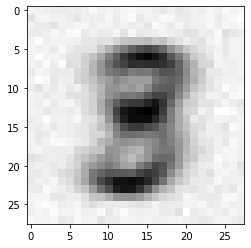

In [11]:
LS = (x3_8_train_tilda.T @ L @ x3_8_train_tilda).diagonal()

plt.imshow(LS.reshape((28,28)).T, cmap="gray")
#plt.colorbar()

As the Laplacian Score implies, the dark pixel(low value) is with low variability whereas the light pixel(high value) is with high variability. Indeed, the digits "3" and "8" almost have the same area in these dark pixles

### Section 3

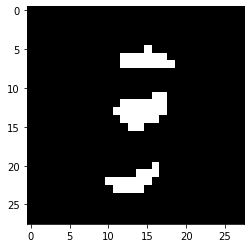

In [12]:
LS_50_indices = np.argsort(LS)[:50] #ordered by small to large
gates = np.zeros(shape=784)
gates[LS_50_indices] = 1
plt.imshow(gates.reshape((28,28)).T, cmap="gray")

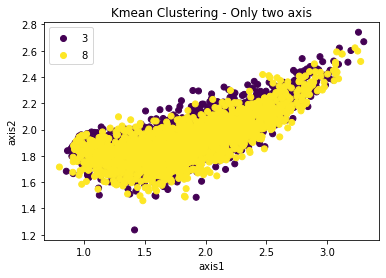

In [13]:
##
x3_8_train_50 = x3_8_train[:, LS_50_indices]
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x3_8_train_50)
transformed_data_train = kmeans.transform(x3_8_train_50)
scat = plt.scatter(x=transformed_data_train[:,0], y=transformed_data_train[:,1], c=y3_8_train)
plt.xlabel("axis1")
plt.ylabel("axis2")
plt.title("Kmean Clustering - Only two axis")
plt.legend(*scat.legend_elements())

In [14]:
#####evaluate clustering accuracy and Normalized Mutual Information (NMI)
print(f"The MNI is: {normalized_mutual_info_score(kmeans.labels_, y3_8_train)}")
kmeans_labels_op1 = kmeans.labels_.copy()
kmeans_labels_op1[kmeans.labels_ == 0] = 3
kmeans_labels_op1[kmeans.labels_ == 1] = 8
kmeans_labels_op2 = kmeans.labels_.copy()
kmeans_labels_op2[kmeans.labels_ == 0] = 8
kmeans_labels_op2[kmeans.labels_ == 1] = 3
max_acc = np.max((accuracy_score(kmeans_labels_op1, y3_8_train), accuracy_score(kmeans_labels_op2, y3_8_train))) #there is two option of combinations
print(f"The max accuracy is: {max_acc}")


The MNI is: 0.0005505587622564704
The max accuracy is: 0.51375


As we can see, with 50 features we get much less accuracy and that because these feature don't represent the different between the digit but they contain the same pixles existing in both digits.
In fact, if we would increase the number of features to a two hundred we would get more accuracy for the reason mentioned above.

### Section 4

In [15]:
##load mnist background images 
train_set_images = np.loadtxt("..\mnist_background_images\mnist_background_images_train.amat")
test_set_images = np.loadtxt("..\mnist_background_images\mnist_background_images_test.amat") #for evaluate the model

In [16]:
print(train_set_images.shape)
print(test_set_images.shape)
#this is weird, I think these two sets is swapped
temp = train_set_images
train_set_images = test_set_images
test_set_images = temp
print(train_set_images.shape)
print(test_set_images.shape)

(12000, 785)
(50000, 785)
(50000, 785)
(12000, 785)


In [17]:
x_train = train_set_images[:, :-1] # except the label, feature shape = [50000, 784]
y_train = train_set_images[:, -1] # [50000, ]


x_test = test_set_images[:, :-1] # [12000, 784]
y_test = test_set_images[:, -1] # [12000, ]

indices_3 = np.where(y_train == 3)
indices_8 = np.where(y_train == 8)

x3_train = x_train[indices_3][:2000] #shape = [2000, 784]
y3_train = y_train[indices_3][:2000] #shape = [2000]

x8_train = x_train[indices_8][:2000]
y8_train = y_train[indices_8][:2000] #shape = [2000]  

x3_8_train_images = np.concatenate((x3_train, x8_train), axis=0) # [4000, 784]
y3_8_train_images = np.concatenate((y3_train, y8_train), axis=0) # [4000, ]

x3_8_train_rand = x3_8_train
y3_8_train_rand = y3_8_train

In [18]:
n_components = 2
cca = CCA(n_components=n_components)
cca.fit(x3_8_train_images, x3_8_train_rand)
x3_8_train_images_c, x3_8_train_rand_c = cca.transform(x3_8_train_images, x3_8_train_rand)


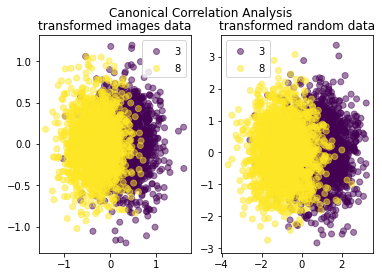

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Canonical Correlation Analysis")
scat1 = ax1.scatter(x=x3_8_train_images_c[:, 0], y=x3_8_train_images_c[:, 1],  c=y3_8_train_images, alpha=0.5)
ax2.title.set_text("transformed random data")
scat2 = ax2.scatter(x=x3_8_train_rand_c[:, 0], y=x3_8_train_rand_c[:, 1],  c=y3_8_train_rand, alpha=0.5)
ax1.title.set_text("transformed images data")
ax1.legend(*scat1.legend_elements())
ax2.legend(*scat2.legend_elements())

### Section 5

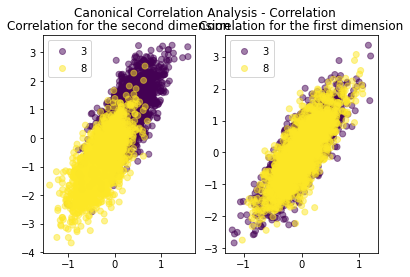

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Canonical Correlation Analysis - Correlation")
scat1 = ax1.scatter(x=x3_8_train_images_c[:, 0], y=x3_8_train_rand_c[:, 0],  c=y3_8_train_images, alpha=0.5)
ax2.title.set_text("Correlation for the first dimension")
scat2 = ax2.scatter(x=x3_8_train_images_c[:, 1], y=x3_8_train_rand_c[:, 1],  c=y3_8_train_rand, alpha=0.5)
ax1.title.set_text("Correlation for the second dimension")
ax1.legend(*scat1.legend_elements())
ax2.legend(*scat2.legend_elements())

As we can see there is correlation betweeen these two coordiantes

In [21]:
####calc of correlation
Cor = x3_8_train_images_c.T @ x3_8_train_rand_c / (np.linalg.norm(x3_8_train_images_c, axis=0, keepdims=True) * np.linalg.norm(x3_8_train_rand_c, axis=0, keepdims=True))
corr = np.trace(Cor)
print(f"The Cor is: {Cor}")
print(f"The correlation is: {corr}")

##we can use the np.corrcoef to calc the correlation:
#np.corrcoef(x3_8_train_images_c[:,0], x3_8_train_rand_c[:,0])
#np.corrcoef(x3_8_train_images_c[:,1], x3_8_train_rand_c[:,1])
#we get the same result

The correlation is: 1.6120306287809822


### Section 6

In [22]:
##The 4-dimensional data is:
cca4_data = np.concatenate((x3_8_train_images_c, x3_8_train_rand_c), axis=1)
print(cca4_data.shape)

(4000, 4)


In [23]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cca4_data)
transformed_cca4_data = kmeans.transform(cca4_data)

In [24]:
#####evaluate clustering accuracy and Normalized Mutual Information (NMI)
print(f"The MNI is: {normalized_mutual_info_score(kmeans.labels_, y3_8_train)}")
kmeans_labels_op1 = kmeans.labels_.copy()
kmeans_labels_op1[kmeans.labels_ == 0] = 3
kmeans_labels_op1[kmeans.labels_ == 1] = 8
kmeans_labels_op2 = kmeans.labels_.copy()
kmeans_labels_op2[kmeans.labels_ == 0] = 8
kmeans_labels_op2[kmeans.labels_ == 1] = 3
max_acc = np.max((accuracy_score(kmeans_labels_op1, y3_8_train), accuracy_score(kmeans_labels_op2, y3_8_train))) #there is two option of combinations
print(f"The max accuracy is: {max_acc}")

The MNI is: 0.3808593532142164
The max accuracy is: 0.84625


As we can see we get more accuracy(compared to the previous value 0.811)

### Section 7

In [76]:
##In order to know the number of dims in the optimal space, we can see the correlations(as we saw in the class):
n_components = 20 #max number of components
cca = CCA(n_components=n_components, max_iter=2000)
cca.fit(x3_8_train_images, x3_8_train_rand)
x3_8_train_images_c, x3_8_train_rand_c = cca.transform(x3_8_train_images, x3_8_train_rand)
Cor = x3_8_train_images_c.T @ x3_8_train_rand_c / (np.linalg.norm(x3_8_train_images_c, axis=0, keepdims=True) * np.linalg.norm(x3_8_train_rand_c, axis=0, keepdims=True))
cor_per_dim = Cor.diagonal()

<BarContainer object of 20 artists>

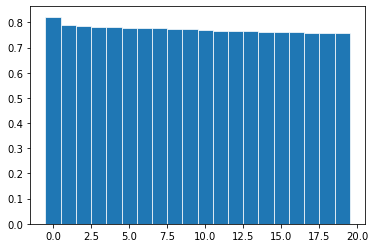

In [77]:
fig, ax = plt.subplots()

ax.bar(np.arange(n_components), cor_per_dim, width=1, edgecolor="white", linewidth=0.7)

(784, 20)

In [89]:
np.sum(cca.x_rotations_[:,0] * cca.x_rotations_[:,16])

-0.053331565488320985

([<matplotlib.axis.XTick at 0x1dcb373ffa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

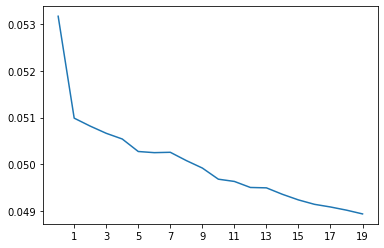

In [27]:
plt.plot(cor_per_dim/sum(cor_per_dim))
plt.xticks([i for i in range(20) if i % 2])

As we can see 1 or 2 dims is enough 

In [58]:
##The 4-dimensional data is:
cca4_data = np.concatenate((x3_8_train_images_c, x3_8_train_rand_c), axis=1)
print(cca4_data.shape)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cca4_data)
transformed_cca4_data = kmeans.transform(cca4_data)
print(f"The MNI is: {normalized_mutual_info_score(kmeans.labels_, y3_8_train)}")
kmeans_labels_op1 = kmeans.labels_.copy()
kmeans_labels_op1[kmeans.labels_ == 0] = 3
kmeans_labels_op1[kmeans.labels_ == 1] = 8
kmeans_labels_op2 = kmeans.labels_.copy()
kmeans_labels_op2[kmeans.labels_ == 0] = 8
kmeans_labels_op2[kmeans.labels_ == 1] = 3
max_acc = np.max((accuracy_score(kmeans_labels_op1, y3_8_train), accuracy_score(kmeans_labels_op2, y3_8_train))) #there is two option of combinations
print(f"The max accuracy is: {max_acc}")

(4000, 2)
The MNI is: 0.3790510847249298
The max accuracy is: 0.8455


### Section 8

I will repeat section 4-6

In [95]:
#first we need to calc the kernel matrices:
#d_images = distance_matrix(x3_8_train_images, x3_8_train_images)
num_samples = x3_8_train_images.shape[0]
d_images = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(i):
        d_images[i, j] = np.linalg.norm(x3_8_train_images[i, :] - x3_8_train_images[j, :], 2)
d_images = d_images + d_images.T #I use for loop since the distance_matrix func takes much more time 
c = 1
sigma = c * np.sort(d_images**2, axis=1)[:,1].max() #this is the Max-Min approach for finding the appropriate sigma.
print(f"The value of sigma is: {sigma}")
K_x = np.exp(-d_images**2/(2*sigma))

#d_rand = distance_matrix(x3_8_train, x3_8_train) #takse much time to calc the distance matrix
d_rand = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(i):
        d_rand[i, j] = np.linalg.norm(x3_8_train[i, :] - x3_8_train[j, :], 2)
d_rand = d_rand + d_rand.T
c = 1
sigma = c * np.sort(d_rand**2, axis=1)[:,1].max() #this is the Max-Min approach for finding the appropriate sigma.
print(f"The value of sigma is: {sigma}")
K_y = np.exp(-d_rand**2/(2*sigma))


The value of sigma is: 83.8544080637031
The value of sigma is: 119.9990643511766


In [96]:
#####Another option to calc the kernel CCA######

"""
##build matrix A and B. These matrices is from the generalized eigenvalue formulation A @ (psi, phi) = ro * B @ (psi, phi)
num_samples = d_images.shape[0]
B = np.zeros((2*num_samples, 2*num_samples))
A = np.zeros((2*num_samples, 2*num_samples))
reg = np.zeros((num_samples, num_samples))
np.fill_diagonal(reg, 1e-04)
B[:num_samples, :num_samples] = K_x @ K_x
B[num_samples:, num_samples:] = K_y @ K_y
A[num_samples:, :num_samples] = K_y @ K_x
A[:num_samples, num_samples:] = K_x @ K_y
w, vr = scipy.linalg.eig(A, b=B)
print(f"The eigenvalues are: {np.abs(w)}") #take a lot of time to calc the eigenvalues
idx = np.abs(w).argsort()[::-1]
vr = vr[:,idx]
vr_x = vr[:num_samples, :]
vr_y = vr[num_samples:, :]
vr_x_c = vr_x[:, 1:3]
vr_y_c = vr_y[:, 1:3]"""


########################

'\n##build matrix A and B. These matrices is from the generalized eigenvalue formulation A @ (psi, phi) = ro * B @ (psi, phi)\nnum_samples = d_images.shape[0]\nB = np.zeros((2*num_samples, 2*num_samples))\nA = np.zeros((2*num_samples, 2*num_samples))\nreg = np.zeros((num_samples, num_samples))\nnp.fill_diagonal(reg, 1e-04)\nB[:num_samples, :num_samples] = K_x @ K_x\nB[num_samples:, num_samples:] = K_y @ K_y\nA[num_samples:, :num_samples] = K_y @ K_x\nA[:num_samples, num_samples:] = K_x @ K_y\nw, vr = scipy.linalg.eig(A, b=B)\nprint(f"The eigenvalues are: {np.abs(w)}") #take a lot of time to calc the eigenvalues\nidx = np.abs(w).argsort()[::-1]\nvr = vr[:,idx]\nvr_x = vr[:num_samples, :]\nvr_y = vr[num_samples:, :]\nvr_x_c = vr_x[:, 1:3]\nvr_y_c = vr_y[:, 1:3]'

In [97]:
n_components = 2
lamb = 1e-04
D = np.identity(num_samples) * lamb

C_00 = K_x @ K_x + D #D for regularization - for invertible kernel
C_00inv = np.linalg.inv(C_00)
C_11 = K_y @ K_y + D
C_11inv = np.linalg.inv(C_11)
C_01 = K_x @ K_y   
C_10 = K_y @ K_x



eigvals, A = np.linalg.eig(np.linalg.multi_dot([C_00inv, C_01, C_11inv, C_10]))
idx = np.abs(eigvals).argsort()[::-1]
eigvals = eigvals[idx]
A = A[:, idx]
A = A[:, : n_components]

eigvals, B =  np.linalg.eig(np.linalg.multi_dot([C_11inv, C_10, C_00inv, C_01]))
idx = np.abs(eigvals).argsort()[::-1]
eigvals = eigvals[idx]
B = B[:, idx]
B = B[:, : n_components]


In [99]:
A.shape, B.shape

((4000, 2), (4000, 2))

In [100]:
A

array([[ 0.0030445 ,  0.00495088],
       [ 0.00655251, -0.01108121],
       [-0.01039009, -0.02542905],
       ...,
       [ 0.02156441,  0.01793914],
       [-0.0135381 ,  0.01735509],
       [-0.01146101,  0.00025667]])

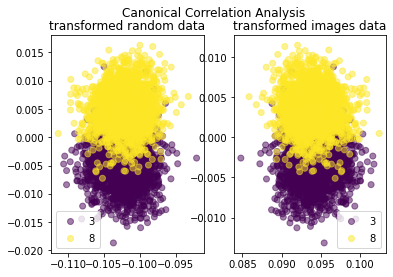

In [101]:
vr_x_c = A
vr_y_c = B
X_hat, Y_hat = (vr_x_c.T @ K_x).T, (vr_y_c.T @ K_y).T
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Canonical Correlation Analysis")
scat1 = ax1.scatter(x=X_hat[:, 0], y=X_hat[:, 1],  c=y3_8_train_images, alpha=0.5)
ax2.title.set_text("transformed images data")
scat2 = ax2.scatter(x=Y_hat[:, 0], y=Y_hat[:, 1],  c=y3_8_train_rand, alpha=0.5)
ax1.title.set_text("transformed random data")
ax1.legend(*scat1.legend_elements())
ax2.legend(*scat2.legend_elements())

We can see more clearly the sepration between the groups

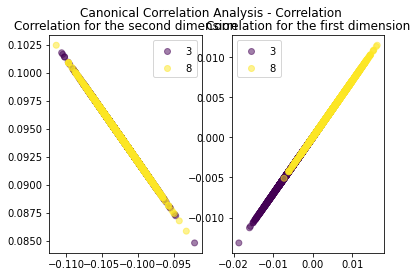

In [102]:
## section 5 for section 8:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Canonical Correlation Analysis - Correlation")
scat1 = ax1.scatter(x=X_hat[:, 0], y=Y_hat[:, 0],  c=y3_8_train_images, alpha=0.5)
ax2.title.set_text("Correlation for the first dimension")
scat2 = ax2.scatter(x=X_hat[:, 1], y=Y_hat[:, 1],  c=y3_8_train_rand, alpha=0.5)
ax1.title.set_text("Correlation for the second dimension")
ax1.legend(*scat1.legend_elements())
ax2.legend(*scat2.legend_elements())

In [103]:
####calc of correlation
Cor = X_hat.T @ Y_hat / (np.linalg.norm(X_hat, axis=0, keepdims=True) * np.linalg.norm(Y_hat, axis=0, keepdims=True))
corr = np.trace(np.abs(Cor))
print(f"The Cor matrix is: {Cor.diagonal()}")
print(f"The correlation is: {corr}")

##we can use the np.corrcoef to calc the correlation:
#np.corrcoef(x3_8_train_images_c[:,0], x3_8_train_rand_c[:,0])
#np.corrcoef(x3_8_train_images_c[:,1], x3_8_train_rand_c[:,1])
#we get the same result

The Cor matrix is: [-0.99999999  0.99998566]
The correlation is: 1.9999856461810586


We get much more correlation with the gaussian kernel

In [104]:
##The 4-dimensional data is:
cca4_data_kernel = np.concatenate((X_hat, Y_hat), axis=1)
print(cca4_data_kernel.shape)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cca4_data_kernel)
transformed_cca4_data_kernel = kmeans.transform(cca4_data_kernel)
#####evaluate clustering accuracy and Normalized Mutual Information (NMI)
print(f"The MNI is: {normalized_mutual_info_score(kmeans.labels_, y3_8_train)}")
kmeans_labels_op1 = kmeans.labels_.copy()
kmeans_labels_op1[kmeans.labels_ == 0] = 3
kmeans_labels_op1[kmeans.labels_ == 1] = 8
kmeans_labels_op2 = kmeans.labels_.copy()
kmeans_labels_op2[kmeans.labels_ == 0] = 8
kmeans_labels_op2[kmeans.labels_ == 1] = 3
max_acc = np.max((accuracy_score(kmeans_labels_op1, y3_8_train), accuracy_score(kmeans_labels_op2, y3_8_train))) #there is two option of combinations
print(f"The max accuracy is: {max_acc}")

(4000, 4)
The MNI is: 0.5798993857111984
The max accuracy is: 0.91425


As we expected, with gaussian kernel whici can capture more than linear dependency, we get more accuracy

#### with this implemetation from github we get the same results


In [91]:

import numpy as np
from scipy.linalg import svd
from sklearn.metrics.pairwise import pairwise_kernels, euclidean_distances

class KCCA(object):
	def __init__(self, n_components=1, epsilon=1.0, kernel="linear", degree=3, gamma=None, coef0=1, n_jobs=1):
		self.n_components = n_components
		self.epsilon = epsilon
		self.kernel = kernel
		self.degree = degree
		self.gamma = gamma
		self.coef0 = coef0
		self.n_jobs = n_jobs

	def fit(self, X, Y):
		ndata_x, nfeature_x = X.shape
		ndata_y, nfeature_y = Y.shape
		if ndata_x != ndata_y:
			raise Exception("Inequality of number of data between X and Y")

		if self.kernel != "precomputed":
			Kx = self._pairwise_kernels(X)
			Ky = self._pairwise_kernels(Y)

		I = self.epsilon * np.identity(ndata_x)
		KxI_inv = np.linalg.inv(Kx + I)
		KyI_inv = np.linalg.inv(Ky + I)
		L = np.dot(KxI_inv, np.dot(Kx, np.dot(Ky, KyI_inv)))
		U, s, Vh = svd(L)

		self.alpha = np.dot(KxI_inv, U[:, :self.n_components])
		self.beta = np.dot(KyI_inv, Vh.T[:, :self.n_components])
		return self

	def _pairwise_kernels(self, X, Y=None):
		return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, n_jobs=self.n_jobs, degree=self.degree, gamma=self.gamma, coef0=self.coef0)


if __name__ == "__main__":
	X = x3_8_train_images
	Y = x3_8_train
	kcca = KCCA(n_components=3, kernel="rbf", n_jobs=1, epsilon=0.1).fit(X, Y)

	"""
	matching on test data
	"""
	alpha = kcca.alpha
	beta = kcca.beta
	

In [94]:
alpha = X_hat
beta = Y_hat
Cor = X_hat.T @ Y_hat / (np.linalg.norm(X_hat, axis=0, keepdims=True) * np.linalg.norm(Y_hat, axis=0, keepdims=True))
corr = np.trace(np.abs(Cor))
print(f"The Cor matrix is: {Cor.diagonal()}")
print(f"The correlation is: {corr}")

The Cor matrix is: [-0.99999999  0.99998566  0.99989557]
The correlation is: 2.9998812191901782
